In [2]:
using StatsPlots, Measures, ColorSchemes, DataFrames, Dates, HTTP, CSV, XLSX
using Statistics: mean, std, cov

In [3]:
Plots.theme(:juno)
Plots.default(palette=:tol_bright)

In [4]:
coin_symbols = XLSX.readxlsx("crypto_currency.xlsx")["Sheet1"]["B2:B11"]

10×1 Matrix{Any}:
 "BTC"
 "ETH"
 "XRP"
 "SOL"
 "LUNA"
 "ADA"
 "AVAX"
 "DOT"
 "DOGE"
 "MATIC"

In [5]:
start_date = Date(2019, 4, 1)
end_date = Date(2022, 3, 31)

2022-03-31

# 0) Downloading and Preparing the Data
I use CoinAPI instead of Alphavantage; it offers more options and has less limitations.

In [203]:
api_key = "ADDB1242-D8BF-4A28-AC47-EC88A728259D"

api_address = "https://rest.coinapi.io/v1/exchangerate/"
api_params = "/USD/history?period_id=1DAY&limit=2000&output_format=csv"

api_time(sdate, edate) = "&time_start=$(sdate)&time_end=$(edate)"

api_time (generic function with 1 method)

In [204]:
for symbol in coin_symbols
    write("exchange_raw/$symbol.csv", HTTP.get(
        api_address * symbol * api_params * api_time(start_date, end_date),
        ["X-CoinAPI-Key" => api_key]).body)
end

In [41]:
for symbol in coin_symbols
    df = CSV.read("exchange_raw/$symbol.csv", DataFrame)[:, [1, 5, 8]]
    rename!(df, [:date, :open, :close])

    df.date = [Date(date[1:10]) for date in df.date]
    insertcols!(df, 4, :returns => (df.close - df.open) ./ df.open)

    CSV.write("exchange_processed/$symbol.csv", df)
end

In [42]:
df = CSV.read("exchange_processed/BTC.csv", DataFrame)
six_month_start = df.date[findfirst(==(end_date - Month(6) + Day(1)), df.date)]
one_year_start = df.date[findfirst(==(end_date - Year(1) + Day(1)), df.date)]

2021-04-01

# 1) Top Five Cryptocurrencies

In [207]:
coins = [CSV.read("exchange_processed/$symbol.csv", DataFrame) for symbol in coin_symbols[1:5]]
coins = [coin[findfirst(==(one_year_start), coin.date):end, :] for coin in coins]

closing_prices = hcat([coin.close for coin in coins]...)
cumulative_returns = hcat([cumprod(coin.close ./ coin.open) .- 1 for coin in coins]...)

# normalize closing prices
closing_prices .-= mean(closing_prices, dims=1)
closing_prices ./= std(closing_prices, dims=1)

# format coin names for plot labels
coin_labels = reshape(string.(coin_symbols[1:5]), 1, 5)

1×5 Matrix{String}:
 "BTC"  "ETH"  "XRP"  "SOL"  "LUNA"

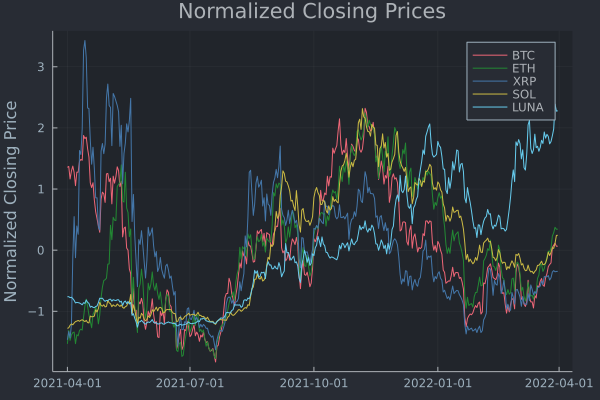

In [208]:
plot(coins[1].date, closing_prices, labels=coin_labels, right_margin=5mm,
    title="Normalized Closing Prices", ylabel="Normalized Closing Price")

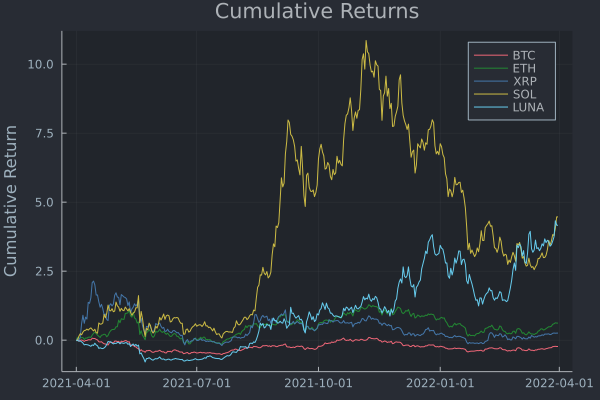

In [209]:
plot(coins[1].date, cumulative_returns, labels=coin_labels, right_margin=5mm,
    title="Cumulative Returns", ylabel="Cumulative Return")

Based on the plots, I would invest in LUNA, but we all know how that would turn out :)

# 2) Effect of Bitcoin Prices on Altcoin Prices

In [210]:
bitcoin = CSV.read("exchange_processed/BTC.csv", DataFrame)
altcoins = [CSV.read("exchange_processed/$symbol.csv", DataFrame)
    for symbol in coin_symbols[2:end]]

bitcoin = bitcoin[findfirst(==(six_month_start), bitcoin.date):end, :]
altcoins = [alt[findfirst(==(six_month_start), alt.date):end, :] for alt in altcoins]

positive_btc_days = findall(>(0), bitcoin.returns)
negative_btc_days = findall(<=(0), bitcoin.returns)

alt_cummul_positive_btc = hcat([
    cumprod((alt.close ./ alt.open)[positive_btc_days]) .- 1 for alt in altcoins]...)
alt_cummul_negative_btc = hcat([
    cumprod((alt.close ./ alt.open)[negative_btc_days]) .- 1 for alt in altcoins]...)

coin_labels = reshape(string.(coin_symbols[2:end]), 1, 9)

1×9 Matrix{String}:
 "ETH"  "XRP"  "SOL"  "LUNA"  "ADA"  "AVAX"  "DOT"  "DOGE"  "MATIC"

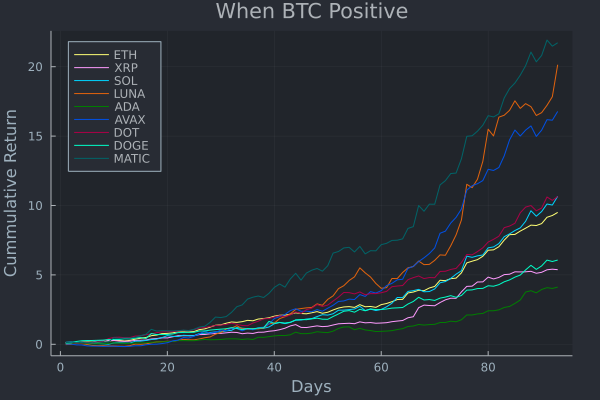

In [291]:
plot(alt_cummul_positive_btc, labels=coin_labels, right_margin=5mm, legend=:topleft,
    palette=distinguishable_colors(10)[2:end], title="When BTC Positive", xlabel="Days", ylabel="Cummulative Return")

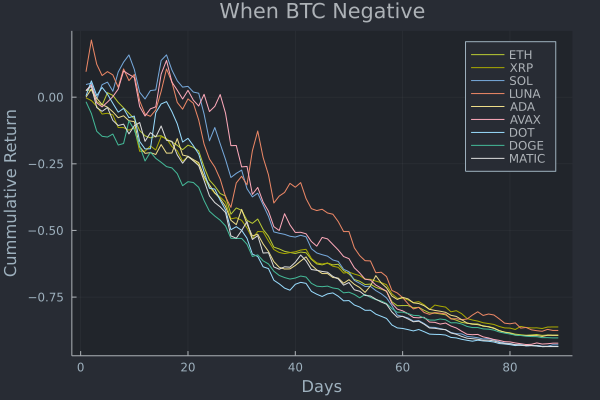

In [212]:
plot(alt_cummul_negative_btc, labels=coin_labels, right_margin=5mm, palette=:tol_light,
    title="When BTC Negative", xlabel="Days", ylabel="Cummulative Return")

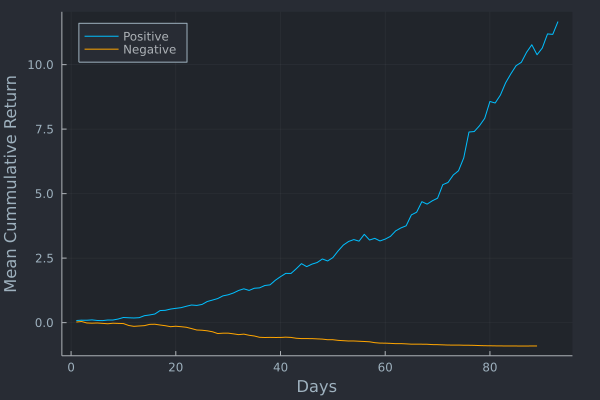

In [213]:
plot(mean(alt_cummul_positive_btc, dims=2), color=:deepskyblue, right_margin=5mm, legend=:topleft,
    palette=:tol_light, label="Positive", xlabel="Days", ylabel="Mean Cummulative Return")
plot!(mean(alt_cummul_negative_btc, dims=2), color=:orange, label="Negative")

Conclusion: Altcoin prices are highly correlated with Bitcoin prices. This makes sense, as all cryptocurrencies are similar assets, with nearly identical functionoality in most cases.

# 3) Sharpe Ratio
To get better data, I use 2021 exchange rates for this problem

In [284]:
coins = [CSV.read("exchange_processed/$symbol.csv", DataFrame) for symbol in ["BTC", "ETH", "XRP"]]
coins = [coin[findfirst(==(Date(2021, 1, 1)), df.date):findlast(==(Date(2021, 12, 31)), df.date), :]
    for coin in coins]

sample_rate = 0.05
portfolio_returns, portfolio_stds, portfolio_sharpe_ratios = (Float64[] for _ in 1:3)
all_weights = Matrix{Float64}(undef, 0, 3)

returns = [prod(coin.close ./ coin.open) - 1 for coin in coins]
covariance_matrix = cov(hcat([cumprod(coin.close ./ coin.open) .- 1 for coin in coins]...))

for weight_btc in 0.0:sample_rate:1.0
    for weight_eth in 0.0:sample_rate:round(1.0-weight_btc, digits=2)
        weight_xrp = 1 - weight_btc - weight_eth
        weights = [weight_btc, weight_eth, weight_xrp]
        all_weights = vcat(all_weights, weights')

        push!(portfolio_returns, weights' * returns)
        push!(portfolio_stds, √(weights' * covariance_matrix * weights))
        push!(portfolio_sharpe_ratios, portfolio_returns[end] / portfolio_stds[end])
    end
end
# fix floating-point inaccuracies for weights
all_weights = round.(all_weights, digits=2)

CSV.write("portfolio.csv", DataFrame(
    "btc weight" => all_weights[:, 1],
    "eth weight" => all_weights[:, 2],
    "xrp weight" => all_weights[:, 3],
    "returns" => portfolio_returns,
    "std" => portfolio_stds,
    "sharpe ratio" =>  portfolio_sharpe_ratios
))

"portfolio.csv"

In [285]:
portfolio = CSV.read("portfolio.csv", DataFrame)
max_sharpe, max_sharpe_idx = findmax(portfolio."sharpe ratio")

(2.866109635003467, 60)

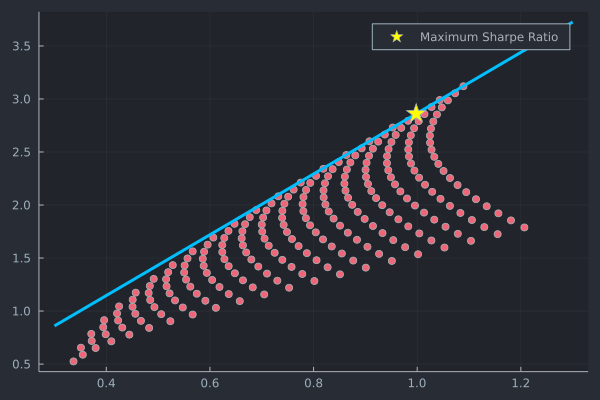

In [286]:
not_max_iterator = setdiff(1:nrow(portfolio), max_sharpe_idx)
scatter(portfolio.std[not_max_iterator], portfolio.returns[not_max_iterator], label=false)
plot!(x -> max_sharpe * x, 0.3, 1.3, label=false, lw=3, color=:deepskyblue)
scatter!([portfolio.std[max_sharpe_idx]], [portfolio.returns[max_sharpe_idx]],
    label="Maximum Sharpe Ratio", mc="Yellow", ms=10, m=:star)

In [287]:
print("Maximum Sharp Ratio = $max_sharpe\nBest BTC Weight = $(portfolio[max_sharpe_idx, 1])\
    \nBest ETH Weight = $(portfolio[max_sharpe_idx, 2])\nBest XRP Weight = $(portfolio[max_sharpe_idx, 3])")

Maximum Sharp Ratio = 2.866109635003467
Best BTC Weight = 0.1
Best ETH Weight = 0.9
Best XRP Weight = 0.0

# 4) Golden Crossover
## Without Transaction Cost

In [28]:
day_interval = 5

coins = [CSV.read("exchange_processed/$symbol.csv", DataFrame) for symbol in coin_symbols]

start_indices = [findfirst(==(one_year_start), coin.date) for coin in coins]
end_indices = [findlast(==(end_date), coin.date) for coin in coins]

golden_crossovers = Matrix{Int}(undef, length(coin_symbols), 2)
best_returns = zeros(length(coin_symbols))
buy_signal_counts = Vector{Int}(undef, length(coin_symbols))

for short_term in day_interval:day_interval:100-day_interval
    for long_term in short_term+day_interval:day_interval:100
        for i in 1:length(coin_symbols)
            moving_average_short = [mean(coins[i].close[j-short_term-1:j-1])
                for j in start_indices[i]-1:end_indices[i]]
            moving_average_long = [mean(coins[i].close[j-long_term-1:j-1])
                for j in start_indices[i]-1:end_indices[i]]
            short_larger = moving_average_short .> moving_average_long

            buy_signals = findall(j -> short_larger[j] & ~short_larger[j-1],
                2:end_indices[i]-start_indices[i]+2) .+ start_indices[i] .- 2
            sell_signals = findall(j -> ~short_larger[j] & short_larger[j-1],
                2:end_indices[i]-start_indices[i]+2) .+ start_indices[i] .- 2

            if sell_signals[1] < buy_signals[1]
                popfirst!(sell_signals)
            elseif length(sell_signals) < length(buy_signals)
                push!(sell_signals, end_indices[i])
            end

            returns = 0
            for (bs, ss) in zip(buy_signals, sell_signals)
                returns += prod(coins[i].close[bs:ss] ./ coins[i].open[bs:ss]) - 1
            end
            if returns > best_returns[i]
                golden_crossovers[i, :] = [short_term long_term]
                buy_signal_counts[i] = length(buy_signals)
                best_returns[i] = returns
            end
        end
    end
end

In [31]:
for i in 1:length(coin_symbols)
    println("$(coin_symbols[i]):\nGolden Crossover: $(golden_crossovers[i, 1]) Days Short-term, \
        $(golden_crossovers[i, 2]) Days Long-term\nReturns for the Golden Crossover Strategy = \
        $(best_returns[i])\nNumber of Buy Signals = $(buy_signal_counts[i])\n")
end

BTC:
Golden Crossover: 30 Days Short-term, 35 Days Long-term
Returns for the Golden Crossover Strategy = 0.43261438308103617
Number of Buy Signals = 10

ETH:
Golden Crossover: 5 Days Short-term, 15 Days Long-term
Returns for the Golden Crossover Strategy = 1.3526275194026047
Number of Buy Signals = 11

XRP:
Golden Crossover: 30 Days Short-term, 40 Days Long-term
Returns for the Golden Crossover Strategy = 1.5489019716218115
Number of Buy Signals = 7

SOL:
Golden Crossover: 15 Days Short-term, 45 Days Long-term
Returns for the Golden Crossover Strategy = 4.936616411408661
Number of Buy Signals = 3

LUNA:
Golden Crossover: 20 Days Short-term, 55 Days Long-term
Returns for the Golden Crossover Strategy = 7.650416924112495
Number of Buy Signals = 3

ADA:
Golden Crossover: 5 Days Short-term, 15 Days Long-term
Returns for the Golden Crossover Strategy = 1.081984425170603
Number of Buy Signals = 12

AVAX:
Golden Crossover: 15 Days Short-term, 55 Days Long-term
Returns for the Golden Crossover

## With Transaction Cost

In [32]:
transaction_cost = 0.05
day_interval = 5

coins = [CSV.read("exchange_processed/$symbol.csv", DataFrame) for symbol in coin_symbols]

start_indices = [findfirst(==(one_year_start), coin.date) for coin in coins]
end_indices = [findlast(==(end_date), coin.date) for coin in coins]

golden_crossovers = Matrix{Int}(undef, length(coin_symbols), 2)
best_returns = zeros(length(coin_symbols))
buy_signal_counts = Vector{Int}(undef, length(coin_symbols))

for short_term in day_interval:day_interval:100-day_interval
    for long_term in short_term+day_interval:day_interval:100
        for i in 1:length(coin_symbols)
            moving_average_short = [mean(coins[i].close[j-short_term-1:j-1])
                for j in start_indices[i]-1:end_indices[i]]
            moving_average_long = [mean(coins[i].close[j-long_term-1:j-1])
                for j in start_indices[i]-1:end_indices[i]]
            short_larger = moving_average_short .> moving_average_long

            buy_signals = findall(j -> short_larger[j] & ~short_larger[j-1],
                2:end_indices[i]-start_indices[i]+2) .+ start_indices[i] .- 2
            sell_signals = findall(j -> ~short_larger[j] & short_larger[j-1],
                2:end_indices[i]-start_indices[i]+2) .+ start_indices[i] .- 2

            if sell_signals[1] < buy_signals[1]
                popfirst!(sell_signals)
            elseif length(sell_signals) < length(buy_signals)
                push!(sell_signals, end_indices[i])
            end

            returns = 0
            for (bs, ss) in zip(buy_signals, sell_signals)
                returns += (1 - transaction_cost) * prod(coins[i].close[bs:ss] ./ coins[i].open[bs:ss]) - 1
            end
            if returns > best_returns[i]
                golden_crossovers[i, :] = [short_term long_term]
                buy_signal_counts[i] = length(buy_signals)
                best_returns[i] = returns
            end
        end
    end
end

In [33]:
for i in 1:length(coin_symbols)
    println("$(coin_symbols[i]):\nGolden Crossover: $(golden_crossovers[i, 1]) Days Short-term, \
        $(golden_crossovers[i, 2]) Days Long-term\nReturns for the Golden Crossover Strategy = \
        $(best_returns[i])\nNumber of Buy Signals = $(buy_signal_counts[i])\n")
end

BTC:
Golden Crossover: 10 Days Short-term, 95 Days Long-term
Returns for the Golden Crossover Strategy = 0.2618991225768912
Number of Buy Signals = 2

ETH:
Golden Crossover: 5 Days Short-term, 15 Days Long-term
Returns for the Golden Crossover Strategy = 0.7349961434324738
Number of Buy Signals = 11

XRP:
Golden Crossover: 30 Days Short-term, 40 Days Long-term
Returns for the Golden Crossover Strategy = 1.1214568730407206
Number of Buy Signals = 7

SOL:
Golden Crossover: 15 Days Short-term, 45 Days Long-term
Returns for the Golden Crossover Strategy = 4.589785590838227
Number of Buy Signals = 3

LUNA:
Golden Crossover: 20 Days Short-term, 55 Days Long-term
Returns for the Golden Crossover Strategy = 7.167896077906869
Number of Buy Signals = 3

ADA:
Golden Crossover: 15 Days Short-term, 35 Days Long-term
Returns for the Golden Crossover Strategy = 0.7242481646988596
Number of Buy Signals = 5

AVAX:
Golden Crossover: 15 Days Short-term, 55 Days Long-term
Returns for the Golden Crossover 

# 5) Prime Numbers

In [81]:
function is_prime(n::Integer)
    if n <= 0
        error("$n is not a positive integer!")
    elseif n == 1
        return false
    end

    for i in 2:√n
        if n % i == 0
            return false
        end
    end
    return true
end

is_prime (generic function with 1 method)

In [82]:
is_prime(11)

true

In [83]:
is_prime(4)

false

In [84]:
is_prime(1)

false

In [85]:
is_prime(-2)

LoadError: -2 is not a positive integer!

# 6) The Best Day for Trading

In [43]:
coins = [CSV.read("exchange_processed/$symbol.csv", DataFrame) for symbol in coin_symbols[1:5]]
best_buy_days = [coin.date[argmax(coin.returns)] for coin in coins]
best_sell_days = [coin.date[argmin(coin.returns)] for coin in coins]

println("Best Days for Buying:")
for i in 1:length(coins)
    println("$(coin_symbols[i]): $(best_buy_days[i]), Return = $(maximum(coins[i].returns))")
end
println("\nBest Days for Selling:")
for i in 1:length(coins)
    println("$(coin_symbols[i]): $(best_sell_days[i]), Return = $(-minimum(coins[i].returns))")
end

Best Days for Buying:
BTC: 2020-05-05, Return = 3.695919178067105
ETH: 2021-01-03, Return = 0.2572554891928071
XRP: 2021-01-30, Return = 0.5751516955832784
SOL: 2020-05-05, Return = 3.4553961023715782
LUNA: 2020-05-05, Return = 3.4561405935494767

Best Days for Selling:
BTC: 2020-03-12, Return = 0.38970182899499517
ETH: 2020-03-12, Return = 0.44348013086482324
XRP: 2020-12-23, Return = 0.41789575435967535
SOL: 2019-04-21, Return = 0.6784869186690974
LUNA: 2019-11-01, Return = 0.5688971679657586


In [44]:
month_start_indices = [findall(d -> Day(d) == Day(1), coin.date) for coin in coins]
month_start_dates = [coin.date[msi] for (coin, msi) in zip(coins, month_start_indices)]
for i in 1:length(month_start_indices)
    push!(month_start_indices[i], nrow(coins[i]) + 1)
end
monthly_returns = [[prod((coin.close ./ coin.open)[msi[i-1]:msi[i]-1])-1 for i in 2:length(msi)]
    for (coin, msi) in zip(coins, month_start_indices)]

best_buy_months = [msd[argmax(mr)] for (msd, mr) in zip(month_start_dates, monthly_returns)]
best_sell_months = [msd[argmin(mr)] for (msd, mr) in zip(month_start_dates, monthly_returns)]
println("Best Months for Buying:")
for i in 1:length(coins) 
    println("$(coin_symbols[i]): $(best_buy_months[i]), Return = $(maximum(monthly_returns[i]))")
end
println("\nBest Months for Selling:")
for i in 1:length(coins)
    println("$(coin_symbols[i]): $(best_sell_months[i]), Return = $(-minimum(monthly_returns[i]))")
end

Best Months for Buying:
BTC: 2020-05-01, Return = 4.066493360807065
ETH: 2019-05-01, Return = 0.7427144109505892
XRP: 2020-11-01, Return = 1.6610260108380959
SOL: 2020-05-01, Return = 2.859493381374758
LUNA: 2019-05-01, Return = 7.7808179757819484

Best Months for Selling:
BTC: 2021-05-01, Return = 0.3760101696676833
ETH: 2020-03-01, Return = 0.41383608191042254
XRP: 2020-12-01, Return = 0.6365814114333979
SOL: 2019-04-01, Return = 0.9569057886491869
LUNA: 2019-07-01, Return = 0.9694714017674282


# 7) Rock, Paper, Scissors Simulation

In [56]:
function outcome(player1_choice::String, player2_choice::String;
        player1_win::String = "player win", player2_win::String = "bot win", draw::String = "draw")
    choices = ["scissors", "rock", "paper"]
    choice1, choice2 = lowercase(player1_choice), lowercase(player2_choice)
    @assert (choice1 in choices && choice2 in choices) "invalid choice!"

    index_difference = findfirst(==(choice1), choices) - findfirst(==(choice2), choices)
    if index_difference == 0
        return draw
    elseif index_difference in (1, 1 - length(choices))
        return player1_win
    else
        return player2_win
    end
end

outcome (generic function with 1 method)

## Human Player vs. Random Bot

In [57]:
using IJulia: readprompt

choices = ["scissors", "rock", "paper"]
player_wins = 0
bot_wins = 0
round = 1
while round <= 5
    player_choice = readprompt("Enter your choice: rock, paper, or scissors?")
    if !(player_choice in choices)
        println("Invalid choice!"); flush(stdout)
        continue
    end
    bot_choice = choices[rand(1:3)]

    oc = outcome(player_choice, bot_choice)
    if oc == "player win"
        player_wins += 1
    elseif oc == "bot win"
        bot_wins += 1
    end

    println("Round $round) player choice: $player_choice, bot choice: $bot_choice, \
        outcome: $(outcome(player_choice, bot_choice))"); flush(stdout)
    round += 1
end

println("\nPlayer score = $player_wins, Bot score = $bot_wins\n")
if player_wins == bot_wins
    println("It's a draw!")
elseif player_wins > bot_wins
    println("The player wins!")
else
    println("The bot wins!")
end

Round 1) player choice: rock, bot choice: paper, outcome: bot win
Round 2) player choice: paper, bot choice: paper, outcome: draw
Round 3) player choice: scissors, bot choice: rock, outcome: bot win
Round 4) player choice: scissors, bot choice: rock, outcome: bot win
Round 5) player choice: scissors, bot choice: paper, outcome: player win

Player score = 1, Bot score = 3

The bot wins!


## Weighted Bot vs. Random Bot

In [71]:
using StatsBase: sample, Weights
number_of_rounds = 1000

weights = Weights([3, 1, 2])
random_bot_choices = rand(choices, number_of_rounds)
weighted_bot_choices = sample(choices, weights)
outcomes = outcome.(weighted_bot_choices, random_bot_choices; player1_win="weighted", player2_win="random")

println("Weighted Bot Wins = $(count(==("weighted"), outcomes))\
    \nRandom Bot Wins = $(count(==("random"), outcomes))\
    \nDraws = $(count(==("draw"), outcomes))")

Weighted Bot Wins = 330
Random Bot Wins = 318
Draws = 352
